# Using the frame context in the TIMIT MLP model

This notebook is an extension of the MLP_TIMIT demo which takes a context of many frames at input to model the same output. So if we have a phoneme, say 'a', instead of just using one vector of 26 features to recognize it, we provide several frames of 26 features before and after the one we are looking at, in order to capture its context. 

This technique helps greatly improve the the quality of the solution, but isn't as scalable as some other solutions. First of all, the greater the context, the more parameters we need to determine. The bigger the model, the more data is required to accurately appraise all the parameters. 

One solution would be to use tied weights, rather then a classical dense layer in such a way that different frames (within the context) use the same set of weights, so the number of weights is kept constant even though we use a larger context.

Furthermore, the model assumes a context of a specific size. It would be nice if the size is unlimited. Again, this would probably make the model impractical if we use a standard dense layer, but could work with the tied weights technique.

Another way of looking at the tied weights solution that has an unlimited context is simply as an RNN. In fact, most implementions of BPTT (used to train RNN) simply unroll the training loop in time and treat the model as a simple MLP with tied weights. This works quite well, but has other issues that are solved using more advanced topologies (LSTM, GRU) which will be dicussed in other notebooks.

In this notebook, we will take an MLP which has an input context of 10 frames on the left and the right side of the analyzed frame. This is done in order to reproduce the resutls from the same paper and thesis as in the MLP_TIMIT notebook.

We begin with the same introductory code as in the previous notebook:

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Reshape
from keras.optimizers import Adam, SGD
from IPython.display import clear_output
from tqdm import *

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 90.0% of memory, cuDNN not available)


## Loading the data

In [3]:
import sys

sys.path.append('../python')

from data import Corpus, History

train=Corpus('../data/TIMIT_train.hdf5',load_normalized=True,merge_utts=False)
dev=Corpus('../data/TIMIT_dev.hdf5',load_normalized=True,merge_utts=False)
test=Corpus('../data/TIMIT_test.hdf5',load_normalized=True,merge_utts=False)

tr_in,tr_out_dec=train.get()
dev_in,dev_out_dec=dev.get()
tst_in,tst_out_dec=test.get()

for u in range(tr_in.shape[0]):
    tr_in[u]=tr_in[u][:,:26]
for u in range(dev_in.shape[0]):    
    dev_in[u]=dev_in[u][:,:26]
for u in range(tst_in.shape[0]):
    tst_in[u]=tst_in[u][:,:26]

## Global training parameters

In [4]:
input_dim=tr_in[0].shape[1]
output_dim=61

hidden_num=250

epoch_num=1000

### 1-hot output

In [5]:
def dec2onehot(dec):
    ret=[]
    for u in dec:
        assert np.all(u<output_dim)
        num=u.shape[0]
        r=np.zeros((num,output_dim))
        r[range(0,num),u]=1
        ret.append(r)
    return np.array(ret)

tr_out=dec2onehot(tr_out_dec)
dev_out=dec2onehot(dev_out_dec)
tst_out=dec2onehot(tst_out_dec)


### Adding frame context

Here we add the frame context. The number 10 is taken from the paper thesis as: *symmetrical
time-windows from 0 to 10 frames*. Now I'm not 100% sure (and it's not  explained anywhere), but I assume this means 10 frames on the left and 10 on the right (i.e. symmetrical), which gives 21 frames alltogether. It's written elsewhere that 0 means no context and uses one frame.

In Keras/Python we implement this in a slightly roundabout way: instead of duplicating the data explicitly, we merely make a 3D array that contains the references to the same data ranges in different cells. In other words, if we make an array where each utterance has a shape $(time\_steps, context*frame\_size)$, I think it would take more memory than by using the shape $(time\_steps,context,frame\_size)$, because in the latter case the same vector (located somewhere in the memory) can be reused in different cotenxts and time steps.

In [6]:
#adds context to data
ctx_fr=10
ctx_size=2*ctx_fr+1

def ctx(data):
    ret=[]
    for utt in data:
        l=utt.shape[0]
        ur=[]
        for t in range(l):
            f=[]
            for s in range(t-ctx_fr,t+ctx_fr+1):
                if(s<0):
                    s=0
                if(s>=l):
                    s=l-1
                f.append(utt[s,:])
            ur.append(f)
        ret.append(np.array(ur))
    return np.array(ret)

tr_in=ctx(tr_in)
dev_in=ctx(dev_in)
tst_in=ctx(tst_in)

In [7]:
print tr_in.shape
print tr_in[0].shape

(3696,)
(241, 21, 26)


## Model definition

Since we have an input as a 3D shape, we use a Reshape layer at the start of the model to convert the input frames into a flat vector. Again, this is to save a little memory at the cost of time it takes to reshape the input. Not sure if its worth it or if it even works as intended (ie. saving memory).

Evertyhing else here is the same as with the standard MLP except for the learning rate which has to be lower in order to reproduce the same results as in the thesis.

In [8]:
model = Sequential()

model.add(Reshape(input_shape=(ctx_size,input_dim),target_shape=(ctx_size*input_dim,)))
model.add(Dense(output_dim=hidden_num))
model.add(Activation('sigmoid'))
model.add(Dense(output_dim=output_dim))
model.add(Activation('softmax'))

optimizer= SGD(lr=1e-3,momentum=0.9,nesterov=False)
loss='categorical_crossentropy'
metrics=['accuracy']

model.compile(loss=loss, optimizer=optimizer,metrics=['accuracy'])

## Training

In [9]:
from random import shuffle

tr_hist=History('Train')
dev_hist=History('Dev')
tst_hist=History('Test')

tr_it=range(tr_in.shape[0])

for e in range(epoch_num):
    
    print 'Epoch #{}/{}'.format(e+1,epoch_num)
    sys.stdout.flush()
    
    shuffle(tr_it)
    for u in tqdm(tr_it):
        l,a=model.train_on_batch(tr_in[u],tr_out[u])
        tr_hist.r.addLA(l,a,tr_out[u].shape[0])        
    clear_output()    
    tr_hist.log()
    
    for u in range(dev_in.shape[0]):
        l,a=model.test_on_batch(dev_in[u],dev_out[u])
        dev_hist.r.addLA(l,a,dev_out[u].shape[0])
    dev_hist.log()
    
    
    for u in range(tst_in.shape[0]):
        l,a=model.test_on_batch(tst_in[u],tst_out[u])
        tst_hist.r.addLA(l,a,tst_out[u].shape[0])
    tst_hist.log()            
    
print 'Done!'

Train loss: 0.992871940136
Train PER: 31.781267%
Dev loss: 1.15928447247
Dev PER: 36.047091%
Test loss: 1.19497609138
Test PER: 37.124260%
Done!


## Plotting progress

These can be handy for debugging. If you draw the graph with using different hyperparameters you can establish if it underfits (i.e. the values are still decreasing at the end of the training) or overfits (the minimum is reached earlier and dev/test values begin increasing as train continues to decrease). In this case, you can see hoe the graph changes with different learning rate values. It's impossible to achieve a single optimal value, but this one seems to be fairly good.

(32, 42)

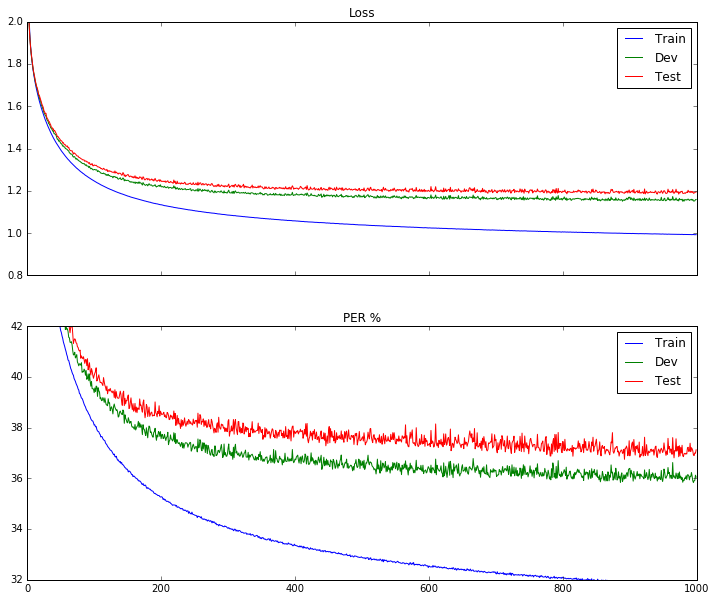

In [10]:
import matplotlib.pyplot as P
%matplotlib inline

fig,ax=P.subplots(2,sharex=True,figsize=(12,10))

ax[0].set_title('Loss')
ax[0].plot(tr_hist.loss,label='Train')
ax[0].plot(dev_hist.loss,label='Dev')
ax[0].plot(tst_hist.loss,label='Test')
ax[0].legend()
ax[0].set_ylim((0.8,2))

ax[1].set_title('PER %')
ax[1].plot(100*(1-np.array(tr_hist.acc)),label='Train')
ax[1].plot(100*(1-np.array(dev_hist.acc)),label='Dev')
ax[1].plot(100*(1-np.array(tst_hist.acc)),label='Test')
ax[1].legend()
ax[1].set_ylim((32,42))

## Final result

Here we reached the value from the thesis just fine, but we used a different learning rate. For some reason, the value from the thesis underfits by a great margin. Not sure if it's a mistake in the thesis or a consequence

In [11]:
print 'Min test PER: {:%}'.format(1-np.max(tst_hist.acc))
print 'Min dev PER epoch: #{}'.format((np.argmax(dev_hist.acc)+1))
print 'Test PER on min dev: {:%}'.format(1-tst_hist.acc[np.argmax(dev_hist.acc)])

Min test PER: 36.749598%
Min dev PER epoch: #996
Test PER on min dev: 36.920527%


Just as before we can check what epoch we reached the optimum.

In [12]:
wer=0.36999999
print 'Epoch where PER reached {:%}: #{}'.format(wer,np.where((1-np.array(tst_hist.acc))<wer)[0][0])

Epoch where PER reached 36.999999%: #723


## Checking the accuracy calculation

When computing the final loss value, we simply measure the mean of the consecutive batch loss values, because we assume that weight updates are performed once per batch and the mean loss of the whole batch is used in the cross entropy to asses the model (just like in MSE). 

With accuracy, however, it's not that simple as using the mean of all the batch accuracies. What we use instad is a weighted average where the weights are determined by the length of each batch/uterance. To make sure this is correct, I do a simple experiment here where I manually count the errors and sample amounts using the predict method. We can see that the values are identical, so using the weighted average is fine.

In [13]:
err=0
cnt=0
for u in range(tst_in.shape[0]):
    p=model.predict_on_batch(tst_in[u])
    c=np.argmax(p,axis=-1)
    err+=np.sum(c!=tst_out_dec[u])
    cnt+=tst_out[u].shape[0]
print 'Manual PER: {:%}'.format(err/float(cnt))
print 'PER using average: {:%}'.format(1-tst_hist.acc[-1])

Manual PER: 37.124260%
PER using average: 37.124260%
